In [2]:
# Separate *.xml and *.jpg files in folders produced by labelImg into file structures to be used by FastAI
# Assume all *.xml and *.jpg files are under ../LabelImg directory (xml中還不能有中文)
# All *.xml and *.jpg files will be renamed as 0, 1, 2, 3, ... and stored in the subdirectories named as Annotations and Images


In [24]:
# ==================可能需要修改的地方=====================================#

labelimg_path = "D:/imgdata/Tea/Disease/"  # *.xml and *.jpg files in the folder(s) produced by labelImg
output_root_path = "../InputDataSu/LabelImgTest2su/"    #root of all output files
xmlfile_path = output_root_path+"Annotations/"  #subdirectory for *.xml files
imgfile_path = output_root_path+"Images/"       #subdirectory for *.jpg files
imgsets_path = output_root_path+"ImageSets/"    #for ImageSets to be stored in .csv format and separated for training or test
testsets_path = output_root_path+"TestImages/"  #subdirectory for *.jpg and *.xml files separated into test.csv
data_counter_start = 0                          #can be changed for different set of data

#all_classes = {"P2":6, "Mg0": 5, "Ca0": 4, "K0": 3, "P0": 2, "N0": 1, "Normal": 0}  # classes to be detected
all_classes = {"tDC01":"tDC01", "tDE02":"tDE02", "tDE03":"tDE03", "tDM04":"tDM04", "tDP05":"tDP05", "tDP06":"tDP06", "tDS07":"tDS07", "tDC08":"tDC08", "tDL09":"tDL09", "tDM10":"tDM10", "tDD11":"tDD11", "tDA12":"tDA12"}  # classes to be detected
train_percent = 0.9    #train比例 (among all dataset, 1-train_percent = test dataset)
# ==================可能需要修改的地方=====================================#

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from PIL import Image
import os

def check_all_images_in_directory(directory):
    # 存儲有問題的圖片文件名
    problematic_images = []
    # 存儲正常的圖片文件名
    good_images = []

    # 遍歷目錄中的所有文件
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            file_path = os.path.join(directory, filename)
            try:
                # 嘗試打開圖片
                with Image.open(file_path) as img:
                    img.verify()  # Verify that this is a valid image
                good_images.append(filename)
            except (IOError, SyntaxError) as e:
                print(f"Cannot open {filename}: {e}")
                problematic_images.append(filename)

    return good_images, problematic_images

# 定義你的圖片文件夾路徑
directory = "D:/imgdata/Tea/Disease/"
good_images, problematic_images = check_all_images_in_directory(directory)

print("Good images:", len(good_images))
print("Problematic images:", len(problematic_images))
if problematic_images:
    print("List of problematic images:")
    for image in problematic_images:
        print(image)


Good images: 2945
Problematic images: 0


In [31]:
IMAGE_SIZE = 264 # 資料集圖片長寬

圖片: 11.JPG - 亮度: 114.63685161564626
圖片: 1356.JPG - 亮度: 90.06741865341816
圖片: 1357.JPG - 亮度: 89.6915172994352
圖片: 1358.JPG - 亮度: 106.4791254947195
圖片: 1359.JPG - 亮度: 125.83126464802741
圖片: 1360.JPG - 亮度: 110.80296000055115
圖片: 1361.JPG - 亮度: 129.71019049981103
圖片: 1362.JPG - 亮度: 105.78688670201878
圖片: 1363.JPG - 亮度: 137.0975933438576
圖片: 1364.JPG - 亮度: 108.09071057531808
圖片: 1365.JPG - 亮度: 120.91606278410283
圖片: 1366.JPG - 亮度: 123.33151742081864
圖片: 1367.JPG - 亮度: 90.41834528468023
圖片: 1368.JPG - 亮度: 110.84650671611237
圖片: 1369.JPG - 亮度: 101.72028853497417
圖片: 1371.JPG - 亮度: 131.8731600568468
圖片: 1372.JPG - 亮度: 128.70538379800223
圖片: 1373.JPG - 亮度: 101.69782735142668
圖片: 1374.JPG - 亮度: 124.12491314523494
圖片: 1375.JPG - 亮度: 120.59818689242672
圖片: 1376.JPG - 亮度: 105.11047056747081
圖片: 1377.JPG - 亮度: 129.29688361166225
圖片: 1378.JPG - 亮度: 128.06335870575083
圖片: 1379.JPG - 亮度: 106.36168218734252
圖片: 138.JPG - 亮度: 126.25206089380197
圖片: 1380.JPG - 亮度: 109.2151348241843
圖片: 1381.JPG - 亮度: 131.

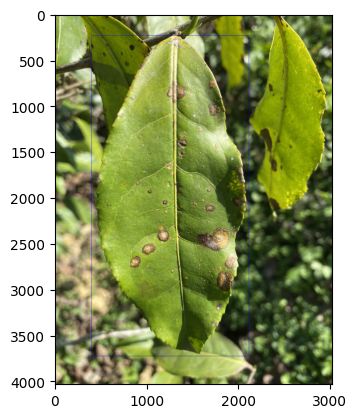

In [36]:
import os
import cv2
import numpy as np
import random
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shutil
import xml.etree.ElementTree as ET
# 拿掉模糊度檢測，因為此檢測會拿掉大量的徵狀清楚背景模糊的照片
IMAGE_SIZE = 264
BRIGHTNESS_LOW_THRESHOLD = 40  # 調整亮度低閾值
BRIGHTNESS_HIGH_THRESHOLD = 200  # 調整亮度高閾值
POOR_QUALITY_FOLDER = "D:/imgdata/Tea/Disease/PoorQuality"  # 儲存品質較差圖片的文件夾

def check_image_quality(image, image_file):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 亮度檢測
    brightness = np.mean(gray)
    is_too_dark = brightness < BRIGHTNESS_LOW_THRESHOLD
    is_too_bright = brightness > BRIGHTNESS_HIGH_THRESHOLD
    
    print(f"圖片: {image_file} - 亮度: {brightness}")
    
    return is_too_dark, is_too_bright

def check_dataset_quality(image_path, annotation_path, all_classes):
    images_list = []
    labels_list = []
    image_files = sorted(os.listdir(image_path))
    annotation_files = sorted(os.listdir(annotation_path))

    missing_annotations = []
    invalid_images = []
    invalid_labels = []
    poor_quality_images = []

    annotation_files_lower = {f.lower(): f for f in annotation_files}

    if not os.path.exists(POOR_QUALITY_FOLDER):
        os.makedirs(POOR_QUALITY_FOLDER)

    for image_file in image_files:
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            image_name = os.path.splitext(image_file)[0]
            annotation_file = f"{image_name}.xml"
            annotation_file_lower = annotation_file.lower()

            if annotation_file_lower in annotation_files_lower:
                actual_annotation_file = annotation_files_lower[annotation_file_lower]
                
                image_path_full = os.path.join(image_path, image_file)
                annotation_path_full = os.path.join(annotation_path, actual_annotation_file)
                image = cv2.imread(image_path_full)
                if image is None:
                    print(f"無法讀取圖片: {image_file}")
                    invalid_images.append(image_file)
                    continue

                # 檢查圖片品質
                is_too_dark, is_too_bright = check_image_quality(image, image_file)
                if is_too_dark or is_too_bright:
                    poor_quality_images.append((image_file, is_too_dark, is_too_bright))
                    shutil.move(image_path_full, os.path.join(POOR_QUALITY_FOLDER, image_file))
                    shutil.move(annotation_path_full, os.path.join(POOR_QUALITY_FOLDER, actual_annotation_file))
                    continue

                # 檢查圖片尺寸
                try:
                    resized_img = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                except Exception as e:
                    print(f"無法縮放圖片: {image_file}, 錯誤: {e}")
                    invalid_images.append(image_file)
                    continue
                
                # 讀取XML標註文件
                with open(annotation_path_full, 'r', encoding='utf-8') as f:
                    soup = BeautifulSoup(f.read(), 'xml')
                    labels = [obj.select_one('name').text for obj in soup.select('object')]
                    valid_labels = [label for label in labels if label in all_classes.values()]
                    
                    if len(valid_labels) != len(labels):
                        invalid_labels.append((image_file, labels))
                    
                    images_list.append(resized_img)
                    labels_list.append(valid_labels)
            else:
                print(f"缺失標註文件: {image_file}")
                missing_annotations.append(image_file)

    return np.array(images_list), labels_list, missing_annotations, invalid_images, invalid_labels, poor_quality_images

def draw_bounding_box(image, xml_content):
    if image is None:
        print("Error: Image is None, cannot draw bounding box.")
        return
    
    # 解析XML內容
    root = ET.fromstring(xml_content)
    
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        # 繪製標註框
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # 顯示圖片
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def split_dataset(images, labels, train_percent):
    total_images = len(images)
    indices = list(range(total_images))
    random.shuffle(indices)
    
    train_size = int(total_images * train_percent)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_images = images[train_indices]
    train_labels = [labels[i] for i in train_indices]
    test_images = images[test_indices]
    test_labels = [labels[i] for i in test_indices]
    
    return train_images, train_labels, test_images, test_labels

# 定义所需的全局变量和文件路径
all_classes = {
    "tDC01": "tDC01",
    "tDE02": "tDE02",
    "tDE03": "tDE03",
    "tDM04": "tDM04",
    "tDP05": "tDP05",
    "tDP06": "tDP06",
    "tDS07": "tDS07",
    "tDC08": "tDC08",
    "tDL09": "tDL09",
    "tDM10": "tDM10",
    "tDD11": "tDD11",
    "tDA12": "tDA12"
}
train_percent = 0.9  # train比例

# 确保以下变量已经定义
labelimg_path = "D:/imgdata/Tea/Disease/"  # 圖片文件夾
xmlfile_path = "D:/imgdata/Tea/Disease/"  # XML標註文件夾

images, labels, missing_annotations, invalid_images, invalid_labels, poor_quality_images = check_dataset_quality(labelimg_path, xmlfile_path, all_classes)

print('圖片資料集形狀:', images.shape)
print('標註資料集長度:', len(labels))
print('缺失標註文件的圖片:', missing_annotations)
print('無效圖片:', invalid_images)
print('無效標籤:', invalid_labels)
print('品質較差的圖片:', poor_quality_images)

if images.size > 0:
    train_images, train_labels, test_images, test_labels = split_dataset(images, labels, train_percent)
    print('訓練集圖片形狀:', train_images.shape)
    print('測試集圖片形狀:', test_images.shape)
    print('訓練集標註樣本:', train_labels[:5])
    print('測試集標註樣本:', test_labels[:5])

# 選擇其中一個品質好的圖片進行標註框顯示（示例）
example_image_path = os.path.join(labelimg_path, "2364.JPG")
example_xml_path = os.path.join(xmlfile_path, "2364.xml")

if os.path.exists(example_image_path) and os.path.exists(example_xml_path):
    with open(example_xml_path, 'r', encoding='utf-8') as file:
        xml_content = file.read()

    image = cv2.imread(example_image_path)
    draw_bounding_box(image, xml_content)
else:
    print("Error: Example image or XML file does not exist.")



In [35]:
# 此cell是包含模糊度檢測 20240531建立的資料集沒有跑這一個步驟
import os
import cv2
import numpy as np
import random
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shutil
import xml.etree.ElementTree as ET

IMAGE_SIZE = 128
BLUR_THRESHOLD = 30  # 調整模糊度閾值
BRIGHTNESS_LOW_THRESHOLD = 40  # 調整亮度低閾值
BRIGHTNESS_HIGH_THRESHOLD = 200  # 調整亮度高閾值
POOR_QUALITY_FOLDER = "D:/imgdata/Tea/PoorQuality/"  # 儲存品質較差圖片的文件夾

def check_image_quality(image, image_file):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 模糊度檢測
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    is_blurry = laplacian_var < BLUR_THRESHOLD
    
    # 亮度檢測
    brightness = np.mean(gray)
    is_too_dark = brightness < BRIGHTNESS_LOW_THRESHOLD
    is_too_bright = brightness > BRIGHTNESS_HIGH_THRESHOLD
    
    print(f"圖片: {image_file} - 模糊度: {laplacian_var}, 亮度: {brightness}")
    
    return is_blurry, is_too_dark, is_too_bright

def move_to_poor_quality_folder(image_path_full, annotation_path_full, image_file, actual_annotation_file):
    try:
        shutil.move(image_path_full, os.path.join(POOR_QUALITY_FOLDER, image_file))
        shutil.move(annotation_path_full, os.path.join(POOR_QUALITY_FOLDER, actual_annotation_file))
    except PermissionError:
        print(f"文件被佔用，無法移動: {image_file} 或 {actual_annotation_file}")

def check_dataset_quality(image_path, annotation_path, all_classes):
    images_list = []
    labels_list = []
    image_files = sorted(os.listdir(image_path))
    annotation_files = sorted(os.listdir(annotation_path))

    missing_annotations = []
    invalid_images = []
    invalid_labels = []
    poor_quality_images = []

    annotation_files_lower = {f.lower(): f for f in annotation_files}

    if not os.path.exists(POOR_QUALITY_FOLDER):
        os.makedirs(POOR_QUALITY_FOLDER)

    for image_file in image_files:
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_name = os.path.splitext(image_file)[0]
            annotation_file = f"{image_name}.xml"
            annotation_file_lower = annotation_file.lower()

            if annotation_file_lower in annotation_files_lower:
                actual_annotation_file = annotation_files_lower[annotation_file_lower]
                
                image_path_full = os.path.join(image_path, image_file)
                annotation_path_full = os.path.join(annotation_path, actual_annotation_file)

                image = cv2.imread(image_path_full)
                if image is None:
                    invalid_images.append(image_file)
                    continue

                # 讀取XML標註文件
                with open(annotation_path_full, 'r', encoding='utf-8') as f:
                    soup = BeautifulSoup(f.read(), 'xml')
                    labels = [obj.select_one('name').text for obj in soup.select('object')]
                    valid_labels = [label for label in labels if label in all_classes.values()]
                    
                    if len(valid_labels) != len(labels):
                        invalid_labels.append((image_file, labels))
                        continue

                    # 檢查標註框內區域的圖片品質
                    for obj in soup.find_all('object'):
                        bndbox = obj.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        
                        # 確保標註框在圖像的有效範圍內
                        xmin = max(0, xmin)
                        ymin = max(0, ymin)
                        xmax = min(image.shape[1], xmax)
                        ymax = min(image.shape[0], ymax)
                        
                        if xmin >= xmax or ymin >= ymax:
                            print(f"無效的標註框: {image_file} - {xmin}, {ymin}, {xmax}, {ymax}")
                            continue
                        
                        # 提取標註框內的區域
                        region = image[ymin:ymax, xmin:xmax]
                        if region.size == 0:
                            print(f"空的標註框區域: {image_file} - {xmin}, {ymin}, {xmax}, {ymax}")
                            continue
                        
                        is_blurry, is_too_dark, is_too_bright = check_image_quality(region, image_file)
                        
                        if is_blurry or is_too_dark or is_too_bright:
                            poor_quality_images.append((image_file, is_blurry, is_too_dark, is_too_bright))
                            move_to_poor_quality_folder(image_path_full, annotation_path_full, image_file, actual_annotation_file)
                            break

                    if image_file in [item[0] for item in poor_quality_images]:
                        continue

                    # 檢查圖片尺寸
                    try:
                        resized_img = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                    except Exception as e:
                        invalid_images.append(image_file)
                        continue
                    
                    images_list.append(resized_img)
                    labels_list.append(valid_labels)
            else:
                missing_annotations.append(image_file)

    return np.array(images_list), labels_list, missing_annotations, invalid_images, invalid_labels, poor_quality_images

def draw_bounding_box(image, xml_content):
    # 解析XML內容
    root = ET.fromstring(xml_content)
    
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        # 繪製標註框
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # 顯示圖片
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# 定义所需的全局变量和文件路径
all_classes = {
    "tDC01": "tDC01",
    "tDE02": "tDE02",
    "tDE03": "tDE03",
    "tDM04": "tDM04",
    "tDP05": "tDP05",
    "tDP06": "tDP06",
    "tDS07": "tDS07",
    "tDC08": "tDC08",
    "tDL09": "tDL09",
    "tDM10": "tDM10",
    "tDD11": "tDD11",
    "tDA12": "tDA12"
}
train_percent = 0.9  # train比例

images, labels, missing_annotations, invalid_images, invalid_labels, poor_quality_images = check_dataset_quality(labelimg_path, labelimg_path, all_classes)

print('圖片資料集形狀:', images.shape)
print('標註資料集長度:', len(labels))
print('缺失標註文件的圖片:', missing_annotations)
print('無效圖片:', invalid_images)
print('無效標籤:', invalid_labels)
print('品質較差的圖片:', poor_quality_images)

if images.size > 0:
    train_images, train_labels, test_images, test_labels = split_dataset(images, labels, train_percent)
    print('訓練集圖片形狀:', train_images.shape)
    print('測試集圖片形狀:', test_images.shape)
    print('訓練集標註樣本:', train_labels[:5])
    print('測試集標註樣本:', test_labels[:5])

# 選擇其中一個品質好的圖片進行標註框顯示（示例）
example_image_path = os.path.join(labelimg_path, "2364.JPG")
example_xml_path = os.path.join(labelimg_path, "2364.xml")

with open(example_xml_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

image = cv2.imread(example_image_path)
draw_bounding_box(image, xml_content)


圖片: 11.JPG - 模糊度: 1088.9657360595327, 亮度: 113.62374109849756
圖片: 1356.JPG - 模糊度: 682.7440492087505, 亮度: 105.52157287939572
圖片: 1357.JPG - 模糊度: 514.541371492075, 亮度: 119.35385652073339
圖片: 1358.JPG - 模糊度: 391.98808394398776, 亮度: 121.94893566669406
圖片: 1359.JPG - 模糊度: 189.2137330139885, 亮度: 142.38576654352715
圖片: 1359.JPG - 模糊度: 67.07258747839336, 亮度: 129.6001013662309
圖片: 1360.JPG - 模糊度: 502.5634809297163, 亮度: 123.14658775213232
圖片: 1360.JPG - 模糊度: 435.0521989551471, 亮度: 109.00177425541736
圖片: 1361.JPG - 模糊度: 35.38033940839149, 亮度: 130.86247130006458
圖片: 1362.JPG - 模糊度: 143.30222584556748, 亮度: 109.12532700235842
圖片: 1363.JPG - 模糊度: 75.59311000047732, 亮度: 100.10521876895834
圖片: 1364.JPG - 模糊度: 157.42055669913702, 亮度: 104.27345998651792
圖片: 1365.JPG - 模糊度: 186.78517331085573, 亮度: 90.37913024948973
圖片: 1366.JPG - 模糊度: 57.870360792879175, 亮度: 131.26194850382743
圖片: 1367.JPG - 模糊度: 99.58178130736047, 亮度: 118.92845616548924
圖片: 1368.JPG - 模糊度: 59.16962119432443, 亮度: 121.6822030036178
圖片: 1368

FileNotFoundError: [Errno 2] No such file or directory: 'D:/imgdata/Tea/Annotations/2364.xml'

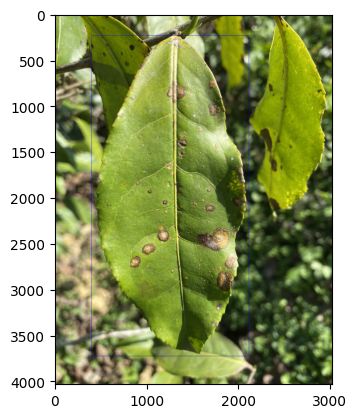

In [36]:
# 選擇其中一個品質好的圖片進行標註框顯示（示例）
example_image_path = os.path.join(labelimg_path, "2364.JPG")
example_xml_path = os.path.join(labelimg_path, "2364.xml")

with open(example_xml_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

image = cv2.imread(example_image_path)
draw_bounding_box(image, xml_content)

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

IMAGE_SIZE = 128  # 根據實際情況調整

input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))  # 調整輸入形狀以適應您的圖片大小

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [56]:
import os
import cv2
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

IMAGE_SIZE = 128

# 定義自編碼器模型
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))  # 根據實際情況調整
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 定義提取區域的函數
def extract_regions(image_path, annotation_path, image_size):
    image = cv2.imread(image_path)
    if image is None:
        print(f"無法讀取圖像文件: {image_path}")
        return []
    
    with open(annotation_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'xml')
    
    regions = []
    for obj in soup.find_all('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(image.shape[1], xmax)
        ymax = min(image.shape[0], ymax)
        
        if xmin >= xmax or ymin >= ymax:
            continue
        
        region = image[ymin:ymax, xmin:xmax]
        if region.size == 0:
            continue

        resized_region = cv2.resize(region, (image_size, image_size))
        regions.append(resized_region)
    
    return regions

def get_annotation_path(image_path, annotation_dir):
    base_name = os.path.basename(image_path)
    possible_extensions = ['.xml']
    for ext in possible_extensions:
        annotation_path = os.path.join(annotation_dir, base_name.replace('.jpg', ext).replace('.jpeg', ext).replace('.png', ext)
                                        .replace('.JPG', ext).replace('.JPEG', ext).replace('.PNG', ext))
        if os.path.exists(annotation_path):
            return annotation_path
    return None

# 準備訓練數據
image_dir = "D:/imgdata/Tea/Disease/"
annotation_dir = "D:/imgdata/Tea/Disease/"
all_images = []

for image_file in os.listdir(image_dir):
    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_dir, image_file)
        annotation_path = get_annotation_path(image_path, annotation_dir)
        
        if annotation_path is None:
            print(f"找不到對應的XML文件: {image_path}")
            continue
        
        regions = extract_regions(image_path, annotation_path, IMAGE_SIZE)
        if regions:
            all_images.extend(regions)
        else:
            print(f"無法從 {image_file} 提取任何區域。")

print(f"提取到的區域數量: {len(all_images)}")

if len(all_images) == 0:
    print("沒有提取到任何圖像區域。請檢查圖像和標註文件。")
else:
    train_images = np.array(all_images).astype('float32') / 255.0

    # 訓練自編碼器
    autoencoder.fit(train_images, train_images,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_split=0.2)



提取到的區域數量: 4216
Epoch 1/50
27/27 [==============================] - 47s 2s/step - loss: 0.6678 - val_loss: 0.5924
Epoch 2/50
27/27 [==============================] - 46s 2s/step - loss: 0.6222 - val_loss: 0.5783
Epoch 3/50
27/27 [==============================] - 45s 2s/step - loss: 0.6112 - val_loss: 0.5746
Epoch 4/50
27/27 [==============================] - 44s 2s/step - loss: 0.6081 - val_loss: 0.5718
Epoch 5/50
27/27 [==============================] - 46s 2s/step - loss: 0.6068 - val_loss: 0.5719
Epoch 6/50
27/27 [==============================] - 46s 2s/step - loss: 0.6055 - val_loss: 0.5703
Epoch 7/50
27/27 [==============================] - 46s 2s/step - loss: 0.6046 - val_loss: 0.5689
Epoch 8/50
27/27 [==============================] - 46s 2s/step - loss: 0.6046 - val_loss: 0.5683
Epoch 9/50
27/27 [==============================] - 46s 2s/step - loss: 0.6032 - val_loss: 0.5676
Epoch 10/50
27/27 [==============================] - 46s 2s/step - loss: 0.6027 - val_loss: 0.5675
Epoc

In [4]:
example_image_path = "D:/imgdata/Tea/Disease/11.jpg"
example_xml_path = "D:/imgdata/Tea/Disease/11.xml"

regions = extract_regions(example_image_path, example_xml_path, IMAGE_SIZE)
print(f"手動測試提取到的區域數量: {len(regions)}")

NameError: name 'extract_regions' is not defined

In [50]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
# 保存自編碼器模型
autoencoder.save('autoencoder_model.h5')

In [51]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
from PIL import Image
import cv2


In [52]:
def load_images_from_folder(folder, image_size, extensions=['.jpg', '.jpeg', '.png', '.bmp']):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in extensions):
            img = Image.open(os.path.join(folder, filename))
            img = img.resize((image_size, image_size))
            img = np.array(img)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

# 加载模型
model = load_model('autoencoder_model.h5')
IMAGE_SIZE = 128  # 假设图片大小为 128x128

original_image_dir = "D:/imgdata/Tea/Disease/"
normal_output_dir = "D:/imgdata/Tea/NormalDisease/"
anomaly_output_dir = "D:/imgdata/Tea/AnomalyDisease/"

# 创建输出目录，如果不存在
os.makedirs(normal_output_dir, exist_ok=True)
os.makedirs(anomaly_output_dir, exist_ok=True)

test_images, filenames = load_images_from_folder(original_image_dir, IMAGE_SIZE)
test_images = test_images / 255.0  # 归一化图像


1/1 [==============================] - 0s 113ms/step


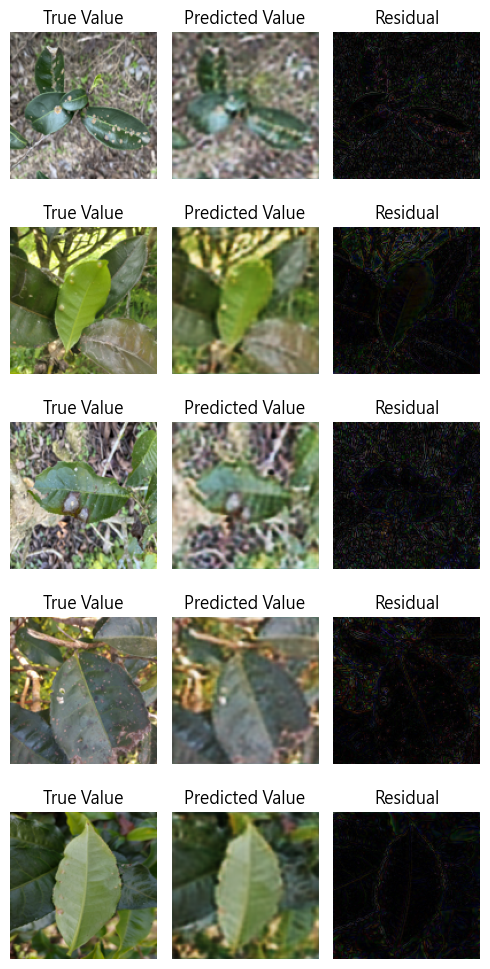

In [53]:
indices = np.random.choice(range(len(test_images)), 5, replace=False)
test_sample = test_images[indices]
y_pred = model.predict(test_sample)
residuals = np.abs(test_sample - y_pred)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(5, 10))
for i in range(5):
    # 真實值
    axes[i, 0].imshow(test_sample[i], cmap='gray')
    axes[i, 0].set_title('True Value')
    axes[i, 0].axis('off')
    # 預測值
    axes[i, 1].imshow(y_pred[i], cmap='gray')
    axes[i, 1].set_title('Predicted Value')
    axes[i, 1].axis('off')
    # 殘差
    axes[i, 2].imshow(residuals[i], cmap='gray')
    axes[i, 2].set_title('Residual')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [56]:
# 计算训练集的 SSIM 和 MSE
ssim_reconstruction_errors = []
mse_reconstruction_errors = []

for i, original_image in enumerate(test_images):
    print(f'第 {i + 1} 張圖片')
    pred_image = model.predict(original_image.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3))
    pred_image = pred_image.reshape(IMAGE_SIZE, IMAGE_SIZE, 3)
    
    # 确保输入图像和预测图像具有相同的 dtype
    original_image = original_image.astype(np.float32)
    pred_image = pred_image.astype(np.float32)
    
    ssim_error = ssim(original_image, pred_image, channel_axis=-1)
    mse_error = mse(original_image.flatten(), pred_image.flatten())
    
    ssim_reconstruction_errors.append(ssim_error)
    mse_reconstruction_errors.append(mse_error)

ssim_mean_error = np.mean(ssim_reconstruction_errors)
ssim_std_error = np.std(ssim_reconstruction_errors)
ssim_threshold = ssim_mean_error - 3 * ssim_std_error

mse_mean_error = np.mean(mse_reconstruction_errors)
mse_std_error = np.std(mse_reconstruction_errors)
mse_threshold = mse_mean_error + 3 * mse_std_error

print(f"ssim 閾值: {ssim_threshold}")
print(f"mse 閾值: {mse_threshold}")


第 1 張圖片
1/1 [==============================] - 0s 23ms/step
第 2 張圖片
1/1 [==============================] - 0s 24ms/step
第 3 張圖片
1/1 [==============================] - 0s 24ms/step
第 4 張圖片
1/1 [==============================] - 0s 23ms/step
第 5 張圖片
1/1 [==============================] - 0s 25ms/step
第 6 張圖片
1/1 [==============================] - 0s 23ms/step
第 7 張圖片
1/1 [==============================] - 0s 23ms/step
第 8 張圖片
1/1 [==============================] - 0s 24ms/step
第 9 張圖片
1/1 [==============================] - 0s 24ms/step
第 10 張圖片
1/1 [==============================] - 0s 23ms/step
第 11 張圖片
1/1 [==============================] - 0s 23ms/step
第 12 張圖片
1/1 [==============================] - 0s 24ms/step
第 13 張圖片
1/1 [==============================] - 0s 23ms/step
第 14 張圖片
1/1 [==============================] - 0s 30ms/step
第 15 張圖片
1/1 [==============================] - 0s 23ms/step
第 16 張圖片
1/1 [==============================] - 0s 22ms/step
第 17 張圖片
1/1 [===================

In [54]:
# 使用 SSIM 和 MSE 阈值筛选测试集中的图像
pred_normal = 0
pred_anomaly = 0
for i, img in enumerate(test_images):
    pred_image = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3))
    pred_image = pred_image.reshape(IMAGE_SIZE, IMAGE_SIZE, 3)
    
    # 确保输入图像和预测图像具有相同的 dtype
    img = img.astype(np.float32)
    pred_image = pred_image.astype(np.float32)
    
    ssim_error = ssim(img, pred_image, channel_axis=-1)
    mse_error = mse(img.flatten(), pred_image.flatten())
    
    filename = filenames[i]
    xml_filename = os.path.splitext(filename)[0] + ".xml"
    
    if ssim_error < ssim_threshold or mse_error > mse_threshold:
        print(f'Structural similarity index: {ssim_error}')
        print(f'Mean squared error: {mse_error}')
        print("異常檢測: 異常")
        pred_anomaly += 1
        shutil.copy(os.path.join(original_image_dir, filename), os.path.join(anomaly_output_dir, filename))
        if os.path.exists(os.path.join(original_image_dir, xml_filename)):
            shutil.copy(os.path.join(original_image_dir, xml_filename), os.path.join(anomaly_output_dir, xml_filename))
    else:
        print("異常檢測: 正常")
        pred_normal += 1
        shutil.copy(os.path.join(original_image_dir, filename), os.path.join(normal_output_dir, filename))
        if os.path.exists(os.path.join(original_image_dir, xml_filename)):
            shutil.copy(os.path.join(original_image_dir, xml_filename), os.path.join(normal_output_dir, xml_filename))

print('辨識為正常', pred_normal)
print('辨識為異常:', pred_anomaly)


1/1 [==============================] - 0s 23ms/step
Structural similarity index: 0.6515726447105408
Mean squared error: 0.008436613716185093
異常檢測: 異常
1/1 [==============================] - 0s 23ms/step
異常檢測: 正常
1/1 [==============================] - 0s 23ms/step
異常檢測: 正常
1/1 [==============================] - 0s 24ms/step
異常檢測: 正常
1/1 [==============================] - 0s 23ms/step
異常檢測: 正常
1/1 [==============================] - 0s 24ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 23ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測: 正常
1/1 [==============================] - 0s 23ms/step
異常檢測: 正常
1/1 [==============================] - 0s 22ms/step
異常檢測:

In [62]:
import os
import random
import shutil
import csv
from bs4 import BeautifulSoup

def run_convert(all_classes, input_path, annotation_path, image_path, csv_path, test_path, train_percent=0.9, data_counter_start=0):
    # 確保每個圖像都有對應的.xml文件，否則刪除該圖像
    total_img = os.listdir(input_path)
    total_img = [a for a in total_img if a.endswith("JPG") or a.endswith("png")]
    
    for name in total_img:
        if not os.path.isfile(os.path.join(input_path, name[:-4] + '.xml')):
            print(f"Removing image {name} as it has no corresponding XML file.")
            os.remove(os.path.join(input_path, name))

    # 更新 total_img 清單
    total_img = os.listdir(input_path)
    total_img = [a for a in total_img if a.endswith("JPG") or a.endswith("png")]
    num = len(total_img)
    tv = int(num * (1 - train_percent))
    test_set = random.sample(range(num), tv)

    # Initialize CSV files
    with open(os.path.join(csv_path, 'train.csv'), 'w', newline='', encoding='utf-8') as ftrain, \
         open(os.path.join(csv_path, 'trainLablesOnly.csv'), 'w', newline='', encoding='utf-8') as train_labels_only, \
         open(os.path.join(csv_path, 'test.csv'), 'w', newline='', encoding='utf-8') as ftest:
        train_writer = csv.writer(ftrain)
        trainLablesOnly_writer = csv.writer(train_labels_only)
        test_writer = csv.writer(ftest)
        train_writer.writerow(['fname', 'labels', 'xmin', 'ymin', 'xmax', 'ymax'])
        trainLablesOnly_writer.writerow(['fname', 'labels'])
        test_writer.writerow(['fname', 'labels', 'xmin', 'ymin', 'xmax', 'ymax'])

        label_dict = {}
        image_labels = {}
        data_counter = data_counter_start
        xml_list = os.listdir(input_path)
        xml_list = [a for a in xml_list if a.endswith("xml")]

        for data_file in xml_list:
            xml_path = os.path.join(input_path, data_file)
            with open(xml_path, 'r', encoding='utf-8') as f:
                soup = BeautifulSoup(f.read(), 'xml')
                filename = soup.find('filename').text + '.jpg'  # Assuming the image extension is .jpg

                if filename not in image_labels:
                    image_labels[filename] = set()

                for obj in soup.find_all('object'):
                    label = obj.find('name').text
                    xmin = obj.bndbox.find('xmin').text
                    ymin = obj.bndbox.find('ymin').text
                    xmax = obj.bndbox.find('xmax').text
                    ymax = obj.bndbox.find('ymax').text
                    image_labels[filename].add(label)

                    # Write to the test set or the full training set CSV
                    if data_counter in test_set:
                        test_writer.writerow([filename, label, xmin, ymin, xmax, ymax])
                        # 複製圖像和XML文件到測試資料夾
                        shutil.copy(os.path.join(input_path, filename), os.path.join(test_path, filename))
                        shutil.copy(xml_path, os.path.join(test_path, data_file))
                    else:
                        train_writer.writerow([filename, label, xmin, ymin, xmax, ymax])
                        # 複製圖像和XML文件到訓練資料夾
                        shutil.copy(os.path.join(input_path, filename), os.path.join(image_path, filename))
                        shutil.copy(xml_path, os.path.join(annotation_path, data_file))

                data_counter += 1

        # Write aggregated labels for each image to the training labels only CSV
        for filename, labels in image_labels.items():
            trainLablesOnly_writer.writerow([filename, ' '.join(labels)])

    print('File processing completed.')

# 使用參數呼叫函數
all_classes = {"tDC01": "tDC01", "tDE02": "tDE02", "tDE03": "tDE03", "tDM04": "tDM04", "tDP05": "tDP05", "tDP06": "tDP06", "tDS07": "tDS07", "tDC08": "tDC08", "tDL09": "tDL09", "tDM10": "tDM10", "tDD11": "tDD11", "tDA12": "tDA12"}
input_path = "D:\\imgdata\\Tea\\NormalDisease\\"
annotation_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Annotations\\"
image_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Images\\"
csv_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\"
test_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Test\\"

# 確保所有目錄存在
os.makedirs(annotation_path, exist_ok=True)
os.makedirs(image_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

run_convert(all_classes, input_path, annotation_path, image_path, csv_path, test_path)



File processing completed.


In [60]:
import os
import random
import shutil
import csv
from bs4 import BeautifulSoup

def run_convert(all_classes, input_path, annotation_path, image_path, csv_path, test_path, train_percent=0.9, data_counter_start=0):
    # 確保每個圖像都有對應的.xml文件，否則刪除該圖像
    total_img = os.listdir(input_path)
    total_img = [a for a in total_img if a.endswith("JPG") or a.endswith("png")]

    for name in total_img:
        if not os.path.isfile(os.path.join(input_path, name[:-4] + '.xml')):
            print(f"Removing image {name} as it has no corresponding XML file.")
            os.remove(os.path.join(input_path, name))

    # 更新 total_img 清單
    total_img = os.listdir(input_path)
    total_img = [a for a in total_img if a.endswith("JPG") or a.endswith("png")]
    num = len(total_img)
    tv = int(num * (1 - train_percent))
    test_set = random.sample(range(num), tv)

    # Initialize CSV files
    with open(os.path.join(csv_path, 'train.csv'), 'w', newline='', encoding='utf-8') as ftrain, \
         open(os.path.join(csv_path, 'trainLablesOnly.csv'), 'w', newline='', encoding='utf-8') as train_labels_only, \
         open(os.path.join(csv_path, 'test.csv'), 'w', newline='', encoding='utf-8') as ftest:
        train_writer = csv.writer(ftrain)
        trainLablesOnly_writer = csv.writer(train_labels_only)
        test_writer = csv.writer(ftest)
        train_writer.writerow(['fname', 'labels', 'xmin', 'ymin', 'xmax', 'ymax'])
        trainLablesOnly_writer.writerow(['fname', 'labels'])
        test_writer.writerow(['fname', 'labels', 'xmin', 'ymin', 'xmax', 'ymax'])

        label_dict = {}
        image_labels = {}
        data_counter = data_counter_start
        xml_list = os.listdir(input_path)
        xml_list = [a for a in xml_list if a.endswith("xml")]

        for data_file in xml_list:
            xml_path = os.path.join(input_path, data_file)
            with open(xml_path, 'r', encoding='utf-8') as f:
                soup = BeautifulSoup(f.read(), 'xml')
                filename = soup.find('filename').text + '.jpg'  # Assuming the image extension is .jpg

                if filename not in image_labels:
                    image_labels[filename] = set()

                for obj in soup.find_all('object'):
                    label = obj.find('name').text
                    xmin = obj.bndbox.find('xmin').text
                    ymin = obj.bndbox.find('ymin').text
                    xmax = obj.bndbox.find('xmax').text
                    ymax = obj.bndbox.find('ymax').text
                    image_labels[filename].add(label)

                    # Write to the test set or the full training set CSV
                    if data_counter in test_set:
                        test_writer.writerow([filename, label, xmin, ymin, xmax, ymax])
                    else:
                        train_writer.writerow([filename, label, xmin, ymin, xmax, ymax])

                data_counter += 1

        # Write aggregated labels for each image to the training labels only CSV
        for filename, labels in image_labels.items():
            trainLablesOnly_writer.writerow([filename, ' '.join(labels)])

    print('File processing completed.')

# 使用參數呼叫函數
all_classes = {"tDC01": "tDC01", "tDE02": "tDE02", "tDE03": "tDE03", "tDM04": "tDM04", "tDP05": "tDP05", "tDP06": "tDP06", "tDS07": "tDS07", "tDC08": "tDC08", "tDL09": "tDL09", "tDM10": "tDM10", "tDD11": "tDD11", "tDA12": "tDA12"}
input_path = "D:\\imgdata\\Tea\\NormalDisease\\"
annotation_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Annotations\\"
image_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Images\\"
csv_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\"
test_path = "C:\\Users\\user\\Desktop\\Tea disease identification model\\pre\\InputDataSu\\test06032024\\Test\\"

# 確保所有目錄存在
os.makedirs(annotation_path, exist_ok=True)
os.makedirs(image_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

run_convert(all_classes, input_path, annotation_path, image_path, csv_path, test_path)



File processing completed.
